DEEP FAKE MODEL

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
!ls "/content/drive/MyDrive/"

'10 self.jpg'	    'Abhinav resume.pdf'       'Deepfake Dataset'  'Untitled spreadsheet.gsheet'
'12 (1).jpg'	    'Approaching data.gsheet'   Deep_Fake.ipynb
 12.jpg		     certificate.pdf	        LoR.pdf
 1655396564339.pdf  'Colab Notebooks'	       'Plant Dataset'


In [24]:
!ls "/content/drive/MyDrive/Deepfake Dataset"

deepfake-detection-challenge.zip


In [25]:
import os

# Change to the directory where your dataset is stored
dataset_path = '/content/drive/MyDrive/Deepfake Dataset'  # Replace with your actual folder path
os.chdir(dataset_path)

# Verify the contents of the directory
print(os.listdir())

['deepfake-detection-challenge.zip']


In [31]:
import zipfile

# Path to the zip file
zip_path = os.path.join(dataset_path, 'deepfake-detection-challenge.zip')

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

# Verify the contents of the directory after unzipping
print(os.listdir())

['deepfake-detection-challenge.zip', 'sample_submission.csv', 'test_videos', 'train_sample_videos']


In [35]:
import os
import pandas as pd
import json

# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Deepfake Dataset'
train_path = os.path.join(dataset_path, 'train_sample_videos')

# Path to metadata.json
metadata_path = os.path.join(train_path, 'metadata.json')

# Check if metadata.json exists
if not os.path.exists(metadata_path):
    print(f"metadata.json not found at: {metadata_path}")
else:
    # Load metadata.json
    with open(metadata_path, 'r') as file:
        metadata = json.load(file)

    # Convert metadata into a DataFrame
    metadata_list = [{'filename': key, **value} for key, value in metadata.items()]
    df = pd.DataFrame(metadata_list)

    # Drop unnecessary columns (if any)
    data = df.drop(['split', 'original'], axis=1)

    # Update file paths to include the full path to each video
    data['filename'] = data['filename'].apply(lambda x: os.path.join(train_path, x))

    # Convert labels to binary (0 for REAL, 1 for FAKE)
    data['label'] = data['label'].apply(lambda x: 0 if x == 'REAL' else 1)

    # Display label distribution
    print("Label distribution:")
    print(data['label'].value_counts())

    # Display the processed data
    print("\nProcessed data:")
    print(data.info())
    print(data.head())

Label distribution:
label
1    323
0     77
Name: count, dtype: int64

Processed data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  400 non-null    object
 1   label     400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB
None
                                            filename  label
0  /content/drive/MyDrive/Deepfake Dataset/train_...      1
1  /content/drive/MyDrive/Deepfake Dataset/train_...      1
2  /content/drive/MyDrive/Deepfake Dataset/train_...      0
3  /content/drive/MyDrive/Deepfake Dataset/train_...      1
4  /content/drive/MyDrive/Deepfake Dataset/train_...      1


In [36]:
data['label'].value_counts()

,count
label,
1,323
0,77


In [37]:
data

,filename,label
0,/content/drive/MyDrive/Deepfake Dataset/train_...,1
1,/content/drive/MyDrive/Deepfake Dataset/train_...,1
2,/content/drive/MyDrive/Deepfake Dataset/train_...,0
3,/content/drive/MyDrive/Deepfake Dataset/train_...,1
4,/content/drive/MyDrive/Deepfake Dataset/train_...,1
...,...,...
395,/content/drive/MyDrive/Deepfake Dataset/train_...,1
396,/content/drive/MyDrive/Deepfake Dataset/train_...,1
397,/content/drive/MyDrive/Deepfake Dataset/train_...,1
398,/content/drive/MyDrive/Deepfake Dataset/train_...,0


In [44]:
import cv2
import os

def preprocess_frame(frame):
    """Preprocesses a frame by resizing and normalizing it.

    Args:
        frame (numpy.ndarray): Input frame.

    Returns:
        numpy.ndarray: Preprocessed frame.
    """
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame.astype('float32') / 255.0
    return normalized_frame

def extract_preprocess_frames(video_path, label, save_dir):
    """Extracts, preprocesses frames from a video, saves them, and returns paths with labels.

    Args:
        video_path (str): Path to the video file.
        label (str): Label for the video (e.g., "real", "deepfake").
        save_dir (str): Directory to save the extracted frames.

    Returns:
        list: List of tuples containing frame paths and their corresponding labels.
    """
    cap = cv2.VideoCapture(video_path)
    frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_frames = []
    frame_index = 0

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    while frame_index < frames_count:
        ret, frame = cap.read()
        if ret:
            processed_frame = preprocess_frame(frame)

            # Save the frame as an image
            filename = f"{os.path.basename(video_path)}_{label}_{frame_index}.jpg"
            save_path = os.path.join(save_dir, filename)
            cv2.imwrite(save_path, processed_frame * 255)  # Convert back to uint8 for saving

            processed_frames.append((save_path, label))
            frame_index += 3  # Skip 2 frames between extracted frames
        else:
            break

    cap.release()
    return processed_frames

def process_video_data(data, save_dir):
    """Processes all videos in the dataset and extracts frames.

    Args:
        data (pd.DataFrame): DataFrame containing video filenames and labels.
        save_dir (str): Directory to save the extracted frames.

    Returns:
        pd.DataFrame: DataFrame containing frame paths and labels.
    """
    all_frames = []

    for index, row in data.iterrows():
        video_path = row['filename']
        label = row['label']
        label_str = "real" if label == 0 else "deepfake"  # Convert label to string
        frames = extract_preprocess_frames(video_path, label_str, save_dir)
        all_frames.extend(frames)

    # Convert the list of tuples to a DataFrame
    all_frames_df = pd.DataFrame(all_frames, columns=['frame_path', 'label'])
    return all_frames_df

# Create a directory to save extracted frames
save_dir = "/content/extracted_frames"
os.makedirs(save_dir, exist_ok=True)

# Process the video data and extract frames
all_frames_df = process_video_data(data, save_dir)

# Display the first few rows of the processed frames DataFrame
print(all_frames_df.head())

                                          frame_path     label
0  /content/extracted_frames/aagfhgtpmv.mp4_deepf...  deepfake
1  /content/extracted_frames/aagfhgtpmv.mp4_deepf...  deepfake
2  /content/extracted_frames/aagfhgtpmv.mp4_deepf...  deepfake
3  /content/extracted_frames/aagfhgtpmv.mp4_deepf...  deepfake
4  /content/extracted_frames/aagfhgtpmv.mp4_deepf...  deepfake


In [45]:
all_frames_df

,frame_path,label
0,/content/extracted_frames/aagfhgtpmv.mp4_deepf...,deepfake
1,/content/extracted_frames/aagfhgtpmv.mp4_deepf...,deepfake
2,/content/extracted_frames/aagfhgtpmv.mp4_deepf...,deepfake
3,/content/extracted_frames/aagfhgtpmv.mp4_deepf...,deepfake
4,/content/extracted_frames/aagfhgtpmv.mp4_deepf...,deepfake
...,...,...
39995,/content/extracted_frames/eukvucdetx.mp4_deepf...,deepfake
39996,/content/extracted_frames/eukvucdetx.mp4_deepf...,deepfake
39997,/content/extracted_frames/eukvucdetx.mp4_deepf...,deepfake
39998,/content/extracted_frames/eukvucdetx.mp4_deepf...,deepfake


In [46]:
all_frames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   frame_path  40000 non-null  object
 1   label       40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [47]:
all_frames_df['label'].value_counts()

,count
label,
deepfake,32300
real,7700


In [48]:
from sklearn.model_selection import train_test_split

train_df , test_df = train_test_split(all_frames_df,test_size=0.3,random_state=42)

In [49]:
print(f"Train df shape:{train_df.shape}")
print(f"Test df shape:{test_df.shape}")

Train df shape:(28000, 2)
Test df shape:(12000, 2)


In [50]:
train_df['label'].value_counts()

,count
label,
deepfake,22535
real,5465


In [51]:
import cv2
from tensorflow.keras.applications import VGG16  # Replace with your chosen pre-trained CNN
from tensorflow.keras.layers import Flatten, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image loading and augmentatio

In [52]:
img_height = 224
img_width =224

In [53]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [54]:

def create_data_generator(dataframe, batch_size, target_size=(img_height, img_width)):
  """
  Creates an image data generator from a DataFrame containing image paths and labels.

  Args:
      dataframe (pandas.DataFrame): The DataFrame containing image paths and labels.
      batch_size (int): The number of images to process together in each batch.
      target_size (tuple, optional): The desired height and width for resizing images. Defaults to (img_height, img_width).

  Returns:
      ImageDataGenerator: The created image data generator object.
  """

  # Get image paths and labels from the DataFrame (adjust column names if needed)
  image_paths = dataframe["frame_path"].tolist()
  labels = dataframe["label"].tolist()

  datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

  # Use flow_from_dataframe to load images and labels from the DataFrame
  generator = datagen.flow_from_dataframe(
      dataframe=dataframe,
      directory=None,
      x_col="frame_path",
      y_col="label",
      target_size=target_size,
      batch_size=batch_size,
      class_mode='binary'
  )

  return generator




In [55]:
batch_size=128
train_generator = create_data_generator(train_df, batch_size=batch_size)
validation_generator = create_data_generator(test_df, batch_size=batch_size)


Found 28000 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


In [56]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

# Define image dimensions
img_height, img_width = 224, 224  # ResNet50 expects 224x224 images

# Load pre-trained ResNet model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model (optional, adjust based on fine-tuning strategy)
base_model.trainable = False

# Create the new model on top
inputs = Input(shape=(img_height, img_width, 3))

# No Rescaling layer needed if ImageDataGenerator rescaled to (0, 1)
x = base_model(inputs, training=False)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu')(x)  # Corrected the typo here
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Reshape((1, x.shape[-1]))(x)
lstm_out = Bidirectional(LSTM(units=128, return_sequences=False))(x)
outputs = Dense(1, activation='sigmoid')(lstm_out)

# Define the model
model = Model(inputs, outputs)

# Display the model summary
model.summary(show_trainable=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resnet50 (Functional)               │ (None, 7, 7, 2048)           │    23,587,712 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d (Conv2D)                     │ (None, 6, 6, 64)             │       524,352 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d (MaxPooling2D)        │ (None, 3, 3, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ (None, 1, 1, 128)            │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 128)                  │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ reshape (Reshape)                   │ (None, 1, 128)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bidirectional (Bidirectional)       │ (None, 256)                  │       263,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │           257 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 24,449,345 (93.27 MB)

 Trainable params: 861,633 (3.29 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

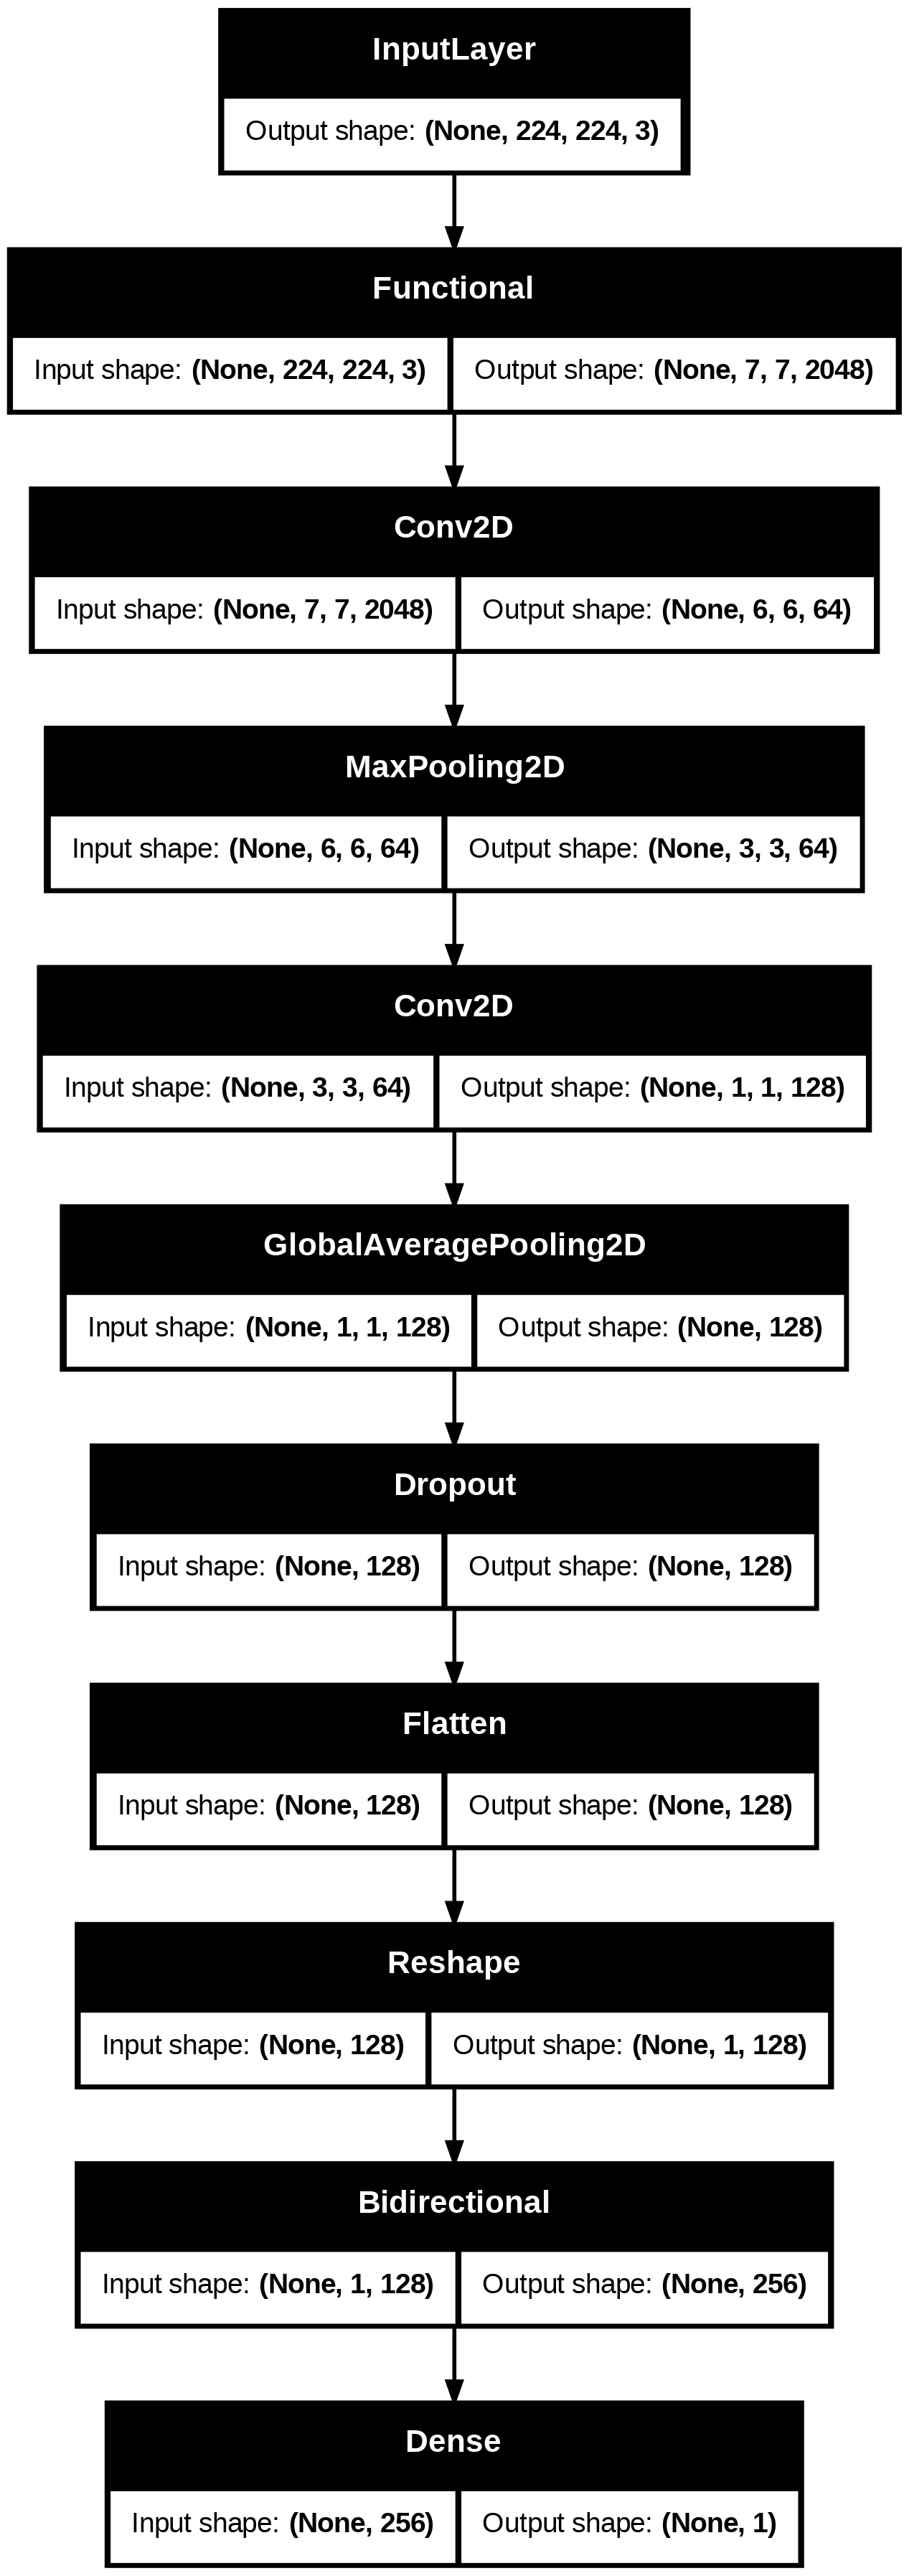

In [57]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [59]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [60]:
# Define training parameters
batch_size = 32
epochs = 5

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


219/875 ━━━━━━━━━━━━━━━━━━━━ 18:32 2s/step - accuracy: 0.7969 - loss: 0.5007

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


875/875 ━━━━━━━━━━━━━━━━━━━━ 548s 606ms/step - accuracy: 0.8030 - loss: 0.4901 - val_accuracy: 0.8139 - val_loss: 0.4579
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 592s 647ms/step - accuracy: 0.8060 - loss: 0.4753 - val_accuracy: 0.8138 - val_loss: 0.4570
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 520s 592ms/step - accuracy: 0.8092 - loss: 0.4691 - val_accuracy: 0.8154 - val_loss: 0.4466
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 560s 590ms/step - accuracy: 0.8095 - loss: 0.4533 - val_accuracy: 0.8175 - val_loss: 0.4232
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 520s 592ms/step - accuracy: 0.8101 - loss: 0.4319 - val_accuracy: 0.8213 - val_loss: 0.4057


In [61]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8115 - loss: 0.4221
Validation Loss: 0.4086686074733734
Validation Accuracy: 0.8201666474342346


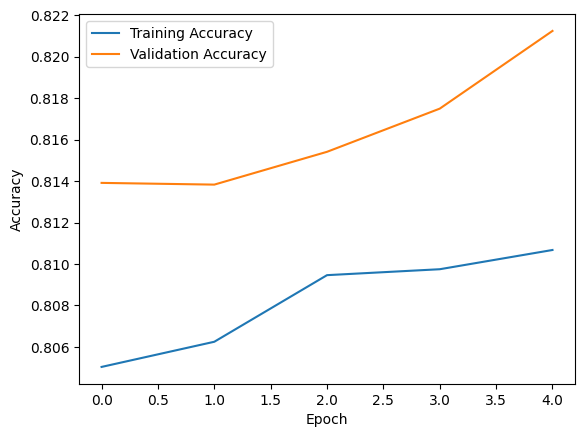

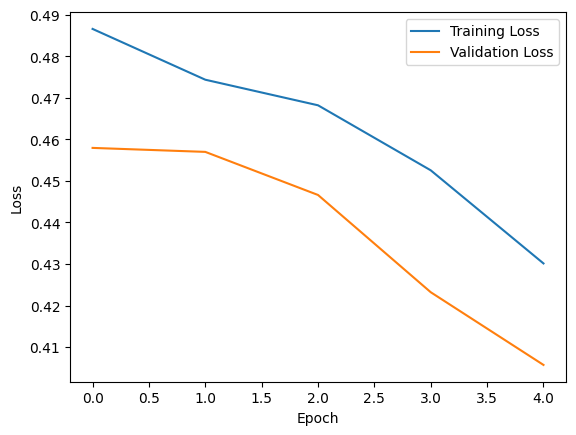

In [62]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
# Save the model
# Save the model in Keras .h5 format
model.save('deepfake_detection_model.h5')

# Download the .h5 model file
from google.colab import files
files.download('deepfake_detection_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
# Save the model in .keras format
model.save('deepfake_detection_model.keras')

# Download the .keras file
from google.colab import files
files.download('deepfake_detection_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
import tensorflow as tf

new_model=tf.keras.models.load_model('my_model.keras')
new_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 6, 6, 64)            │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 1, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,310,980 (96.55 MB)

 Trainable params: 861,633 (3.29 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 861,635 (3.29 MB)

In [68]:
loaded_model = tf.keras.models.load_model('my_model.keras')

In [69]:
import pickle

In [70]:
with open('model_pickle','wb') as f:
  pickle.dump(model,f)

In [71]:
with open('model_pickle','rb') as f:
  mp=pickle.load(f)

In [72]:
# mp.predict()

In [73]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 6, 6, 64)            │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 1, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,172,613 (99.84 MB)

 Trainable params: 861,633 (3.29 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,723,268 (6.57 MB)